In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa

%config IPCompleter.greedy = True

In [5]:
con = sa.create_engine('sqlite:///../Datos_Madrid_2024/airbnb.db')

df = pd.read_sql('df', con = con)

df.head()

,index,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,0,902671779171769624,Habitación centro de Madrid 4,50080380,Centro,Cortes,40.411812,-3.697614,Private room,77,...,f,2,1,1.0,3,4.0,4.67,5.0,6594,Centro
1,1,9753808,Habitación cuqui,41563621,Centro,Embajadores,40.410970,-3.698240,Private room,54,...,f,1,1,1.0,1,5.0,5.00,5.0,6594,Centro
2,2,46899002,Habitación Doble con Baño Compartido,331096767,San Blas - Canillejas,Rejas,40.444300,-3.565950,Private room,55,...,f,2,1,1.0,0,NaN,NaN,NaN,3194,San Blas - Canillejas
3,3,1125891241820979969,SB18-04 Habitación área exclusiva de Madrid,567327895,Centro,Palacio,40.408240,-3.713480,Private room,69,...,f,1,1,1.0,0,NaN,NaN,NaN,6594,Centro
4,4,49895335,Teste,86662970,Ciudad Lineal,San Juan Bautista,40.453560,-3.656380,Private room,200,...,f,2,1,1.0,0,NaN,NaN,NaN,4002,Ciudad Lineal


In [6]:
#Vamos a analizar price y si es el precio del apartamento o si es una habitación, etc...
#Vamos a analizar por distrito también, para ver si cambia en el barrio de Salamanca o en Aluche, para aislar y hacer conteo por distritos
df.distrito.value_counts()
#Cuanto mayor tamaño muestral, mejor

distrito
Centro                   10245
Chamberí                  1619
Salamanca                 1560
Tetuán                    1521
Arganzuela                1407
Carabanchel                957
Ciudad Lineal              905
Retiro                     890
Chamartín                  797
Puente de Vallecas         785
Latina                     719
Moncloa - Aravaca          670
Usera                      593
San Blas - Canillejas      568
Hortaleza                  499
Fuencarral - El Pardo      377
Villaverde                 243
Barajas                    179
Moratalaz                  159
Villa de Vallecas          133
Vicálvaro                   84
Name: count, dtype: int64

In [7]:
df.loc[df.distrito == 'Centro',:].groupby('room_type').price.mean()

room_type
Entire home/apt    135.449674
Private room        71.512663
Shared room         45.291339
Name: price, dtype: float64

**Hay bastante diferencia, por eso hay que analizar esto para estimar los ingresos. Por ejemplo, multiplicar el precio por el número de habitaciones**

Pero cuidado sobreestimando el ingreso, ya que no siempre va a estar completo un apto con 3 habitaciones. Vamos a ajustar

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24910 entries, 0 to 24909
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           24910 non-null  int64  
 1   id                              24910 non-null  int64  
 2   name                            24910 non-null  object 
 3   host_id                         24910 non-null  int64  
 4   neighbourhood_group             24910 non-null  object 
 5   neighbourhood                   24910 non-null  object 
 6   latitude                        24910 non-null  float64
 7   longitude                       24910 non-null  float64
 8   room_type                       24910 non-null  object 
 9   price                           24910 non-null  int64  
 10  minimum_nights                  24910 non-null  int64  
 11  calculated_host_listings_count  24910 non-null  int64  
 12  availability_365                

In [9]:
#Queremos homogeneizar el precio de alquiler, y estimar más correctamente los ingresos cuando está alquilado.
#IMPORTANTE, en vez de beds, en el otro proyecto utiliza habitaciones (bedrooms)
def crear_precio_total(registro):
    if (registro.bedrooms > 1) & ((registro.room_type == 'Private room') | (registro.room_type == 'Shared room')):
        salida = registro.price * registro.bedrooms * 0.7
    else:
        salida = registro.price
    return(salida)

df.apply(crear_precio_total, axis = 1)

0         77.0
1         54.0
2         55.0
3         69.0
4        200.0
         ...  
24905     50.0
24906     55.0
24907     50.0
24908     35.0
24909     31.0
Length: 24910, dtype: float64

In [10]:
df['precio_total'] = df.apply(crear_precio_total, axis = 1)

In [12]:
#Vemos ejemplos a ver si funciona
df[['room_type','price','bedrooms','precio_total']].head(30)

,room_type,price,bedrooms,precio_total
0,Private room,77,1,77.0
1,Private room,54,1,54.0
2,Private room,55,1,55.0
3,Private room,69,1,69.0
4,Private room,200,1,200.0
5,Private room,55,1,55.0
6,Private room,40,1,40.0
7,Entire home/apt,91,3,91.0
8,Private room,45,5,157.5
9,Entire home/apt,114,2,114.0


In [13]:
#Ahora continuamos con la ocupación, nos interesa ponerlo en porcentaje. Usamos técnica de cálculos directos
#availability_365 nos da el número de días que está DISPONIBLE, no el número de días que está OCUPADO
df['ocupacion'] = (((365 - df.availability_365) / 365) * 100).astype('int64')

df[['ocupacion','availability_365']].head(10)

,ocupacion,availability_365
0,100,0
1,100,0
2,100,0
3,100,0
4,0,365
5,100,0
6,100,0
7,100,0
8,100,0
9,100,0


**Vamos a transformar accomodates, bedrooms, beds y number of reviews. Discretizamos para pasarlas de continuas a categóricas y cruzarlas despues con la ocupación o el precio total**

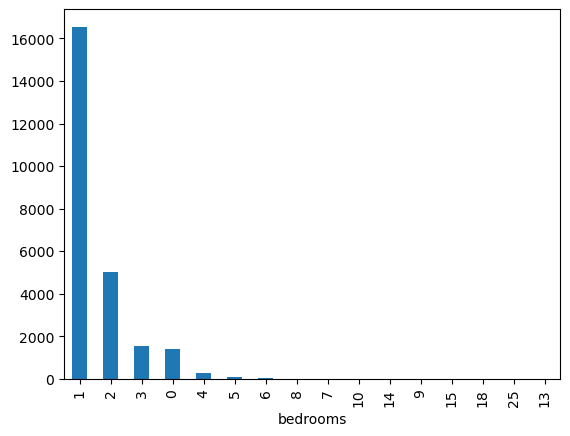

In [14]:
#Discretización manual de bedrooms que tenga sentido en negocio y en número de casos que tenemos
df.bedrooms.value_counts().plot.bar();

In [15]:
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms > 3]
resultados = ['01_Una','02_Dos','03_Tres','04_Cuatro_o_mas']

df['bedrooms_disc'] = np.select(condiciones, resultados, default = -999)

In [16]:
df['bedrooms_disc'].value_counts()

bedrooms_disc
01_Una             16536
02_Dos              5013
03_Tres             1529
-999                1429
04_Cuatro_o_mas      403
Name: count, dtype: int64

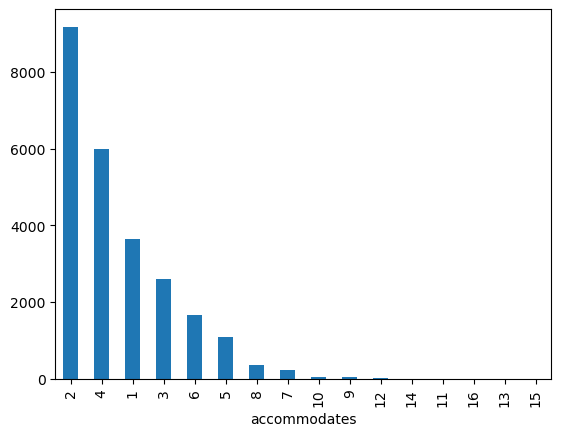

In [17]:
#Discretización de forma automática
df.accommodates.value_counts().plot.bar();

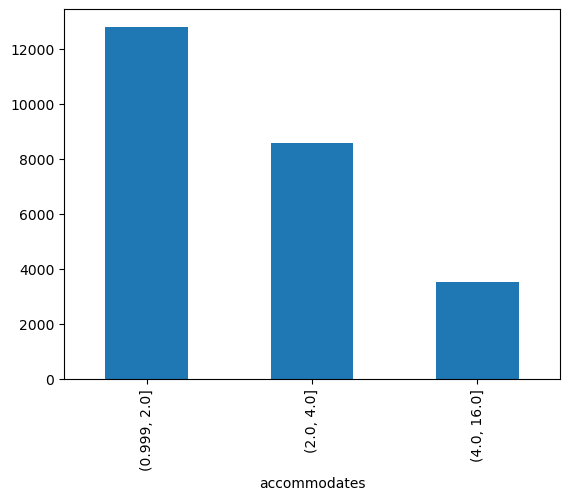

In [18]:
#Replicamos esto de una manera sencilla:
pd.qcut(df.accommodates, [0,0.5,0.8,1]).value_counts().plot.bar();

In [19]:
pd.qcut(df.accommodates, [0,0.5,0.8,1])

0        (0.999, 2.0]
1        (0.999, 2.0]
2        (0.999, 2.0]
3        (0.999, 2.0]
4        (0.999, 2.0]
             ...     
24905    (0.999, 2.0]
24906    (0.999, 2.0]
24907    (0.999, 2.0]
24908    (0.999, 2.0]
24909    (0.999, 2.0]
Name: accommodates, Length: 24910, dtype: category
Categories (3, interval[float64, right]): [(0.999, 2.0] < (2.0, 4.0] < (4.0, 16.0]]

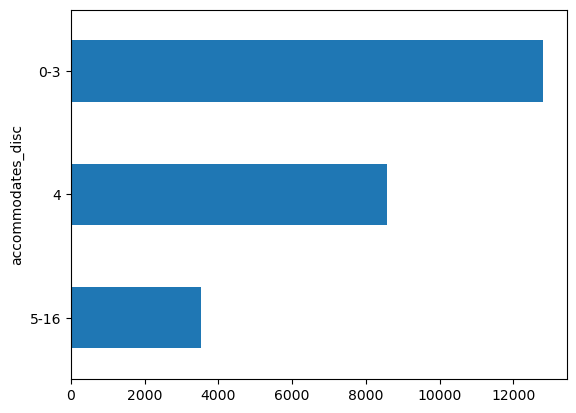

In [21]:
#Personalizar las etiquetas, para que quede más legible y no tener problemas con las bases de datos
df['accommodates_disc'] = pd.qcut(df.accommodates,[0, 0.5, 0.8, 1],
                                 labels = ['0-3','4','5-16'])

df['accommodates_disc'].value_counts().sort_index(ascending = False).plot.barh();

**Ahora lo hacemos con beds**

In [23]:
pd.qcut(df.beds, [0,0.5,0.8,1])

0        (-0.001, 1.0]
1        (-0.001, 1.0]
2        (-0.001, 1.0]
3        (-0.001, 1.0]
4        (-0.001, 1.0]
             ...      
24905    (-0.001, 1.0]
24906    (-0.001, 1.0]
24907    (-0.001, 1.0]
24908    (-0.001, 1.0]
24909    (-0.001, 1.0]
Name: beds, Length: 24910, dtype: category
Categories (3, interval[float64, right]): [(-0.001, 1.0] < (1.0, 2.0] < (2.0, 40.0]]

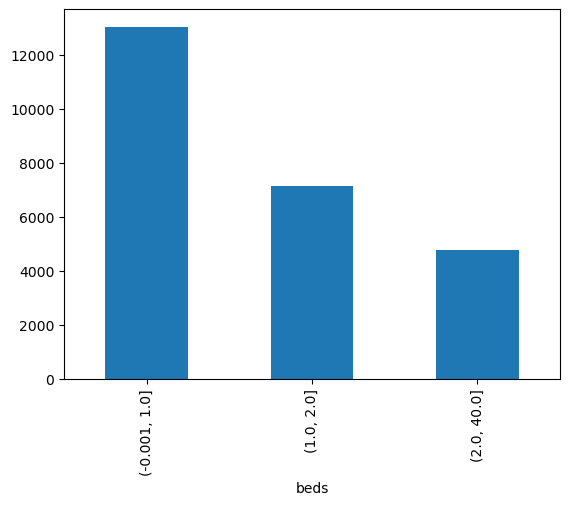

In [24]:
pd.qcut(df.beds,[0, 0.5, 0.8, 1]).value_counts().plot.bar();

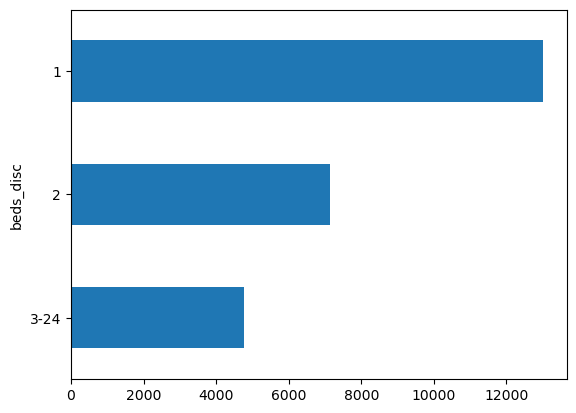

In [25]:
df['beds_disc'] = pd.qcut(df.beds,[0, 0.5, 0.8, 1],
                         labels = ['1','2','3-24'])

df['beds_disc'].value_counts().sort_index(ascending = False).plot.barh();

**Ahora con number of reviews**

In [26]:
pd.qcut(df.number_of_reviews, [0,0.5,0.8,1])

0        (-0.001, 10.0]
1        (-0.001, 10.0]
2        (-0.001, 10.0]
3        (-0.001, 10.0]
4        (-0.001, 10.0]
              ...      
24905    (-0.001, 10.0]
24906    (-0.001, 10.0]
24907      (10.0, 68.0]
24908    (-0.001, 10.0]
24909    (-0.001, 10.0]
Name: number_of_reviews, Length: 24910, dtype: category
Categories (3, interval[float64, right]): [(-0.001, 10.0] < (10.0, 68.0] < (68.0, 1092.0]]

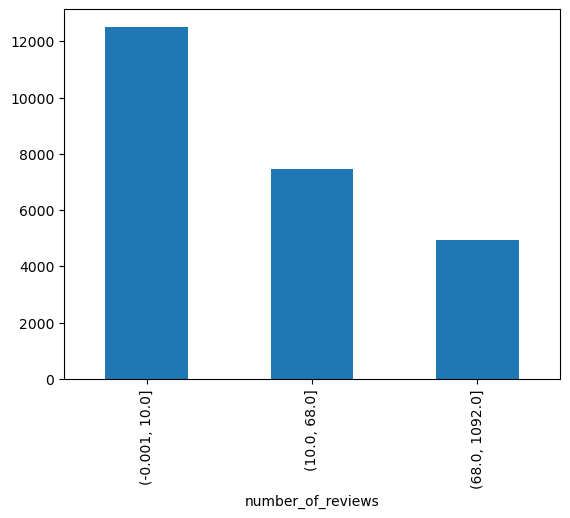

In [27]:
pd.qcut(df.number_of_reviews,[0, 0.5, 0.8, 1]).value_counts().plot.bar();

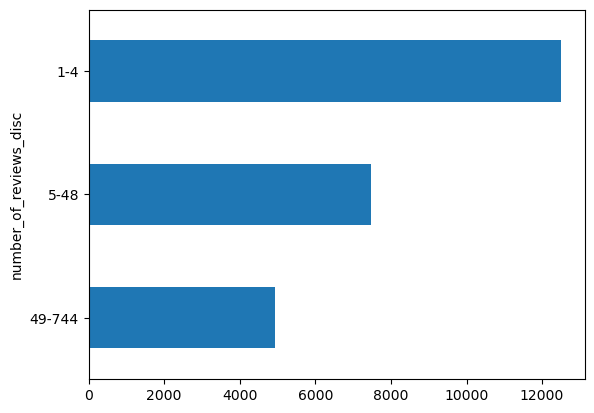

In [28]:
df['number_of_reviews_disc'] = pd.qcut(df.number_of_reviews,[0, 0.5, 0.8, 1],
                                      labels = ['1-4','5-48','49-744'])

df['number_of_reviews_disc'].value_counts().sort_index(ascending = False).plot.barh();

**CREACIÓN DE VARIABLES SOBRE DATOS EXTERNOS** 

En este caso en concreto se podrían hacer muchas cosas con datos externos.

Lo primero, que ya hemos incorporado parcialmente, es la palanca del precio del inmueble.

Decíamos que la podíamos estimar multiplicando los metros cuadrados del inmueble por el precio por m2.

El precio_m2 ya lo hemos conseguido, pero el tamaño del inmueble no lo tenemos en los datos.

Lo que podemos hacer es establecer unos criterios en base al número de habitaciones.

No es perfecto, pero nos servirá de aproximación.

**Estimación de los metros cuadrados del inmueble**

Vamos usar el siguiente algoritmo:

una habitación: m2 = 50
dos habitaciones: m2 = 70
tres habitaciones: m2 = 90
cuatro habitaciones: m2 = 120
cinco o más habitaciones: m2 = 150

In [31]:
#Vamos a estimar el tamaño del piso
condiciones = [df.bedrooms == 1,
               df.bedrooms == 2,
               df.bedrooms == 3,
               df.bedrooms == 4,
               df.bedrooms > 4]

resultados = [50,70,90,120,150]

df['m2'] = np.select(condiciones, resultados, default = -999)

Comprobamos:

In [34]:
df['m2'].value_counts()

m2
 50     16536
 70      5013
 90      1529
-999     1429
 120      265
 150      138
Name: count, dtype: int64

Ahora ya podemos estimar el **precio de compra del inmueble.**

Recordamos que al precio que nos sale le quitábamos un 30% por capacidad de negociación.

In [35]:
df['precio_compra'] = df.m2 * df.precio_m2 * 0.7

Comprobamos:

In [36]:
df[['bedrooms','m2','distrito','precio_m2','precio_compra']].head(20)

,bedrooms,m2,distrito,precio_m2,precio_compra
0,1,50,Centro,6594,230790.0
1,1,50,Centro,6594,230790.0
2,1,50,San Blas - Canillejas,3194,111790.0
3,1,50,Centro,6594,230790.0
4,1,50,Ciudad Lineal,4002,140070.0
5,1,50,Centro,6594,230790.0
6,1,50,Carabanchel,2889,101115.0
7,3,90,Ciudad Lineal,4002,252126.0
8,5,150,Moncloa - Aravaca,5147,540435.0
9,2,70,Hortaleza,4490,220010.0


**Cálculo de la distancia de cada inmueble a la Puerta del Sol**

In [37]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 6372.8 #En km, si usas millas tienes que cambiarlo por 3959.87433

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

Creamos la variable

In [38]:
#Las coordenadas de la Puerta del Sol serán lat1 y lon1
lat1 = 40.4167278
lon1 = -3.7033387

df['pdi_sol'] = df.apply(lambda registro: haversine(lat1,lon1,registro.latitude,registro.longitude),axis = 1)

Comprobamos revisando la distancia media por distritos.

In [39]:
df.groupby('distrito').pdi_sol.mean().sort_values()

distrito
Centro                    0.734680
Arganzuela                1.930994
Chamberí                  2.159331
Retiro                    2.498931
Salamanca                 2.832399
Moncloa - Aravaca         3.125119
Latina                    3.754601
Carabanchel               3.933539
Usera                     3.995925
Chamartín                 4.543991
Puente de Vallecas        4.548435
Tetuán                    4.690383
Moratalaz                 5.011756
Ciudad Lineal             5.121725
Villaverde                7.730218
Fuencarral - El Pardo     7.918060
Hortaleza                 7.989852
San Blas - Canillejas     8.368029
Vicálvaro                 9.047594
Villa de Vallecas         9.279963
Barajas                  11.457700
Name: pdi_sol, dtype: float64

**Guardamos en el DATAMART**

Vamos a guardar esta version como df_preparado

In [40]:
df.to_sql('df_preparado', con = con, if_exists = 'replace')

24910